In [102]:
pip install --user scprep phate magic-impute

Note: you may need to restart the kernel to use updated packages.


In [29]:
# %load /home/dan/.jupyter/firstcell.py
%load_ext autoreload
%autoreload 2

import sys
import os
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

font = {'size'   : 12}
mpl.rc('font', **font)

import numpy as np
import pandas as pd

import scipy
from scipy import stats

import sklearn
import sklearn.cluster
import sklearn.datasets

import phate
import scprep
import magic
import meld
import graphtools as gt

## Identifying gene-regulatory relationships during EMT

In this exercise, we will recreate some of the analysis from [van Dijk et al. (2018)](https://doi.org/10.1016/j.cell.2018.05.061). We will focus on the dataset collected from mammary epithelial cells (HMLE) induced with transforming growth factor β (TGF-β). TGF-β induces HMLE cells to undergo the epithelial-to-mesenchymal transition (EMT), which is an important transition during development and the progression of cancer. During EMT, cells downregulate epithelial markers (such as E-cadherin (CDH1) and epcam (EPCAM)) and upregulate mesenchymal markers (such as vimentin (VIM), fibronectin (FN1) and N-cadherin (CDH2). 

In this experiment, cells were induced with TGF-β for 8 days and then collected for scRNA-seq using inDrops. Because EMT is asynchronous, we observe cells at many stages of differentiation in this dataset. Instead of using a pseudotime tool, we will use VIM as a marker of the EMT progression. We will identify genes that are EMT-relevant as those with a strong association with VIM. From these, we will focus on predicting targets of the transcription factor ZEB1 based on 1) timing of expression and 2) statistical association with ZEB1.


## Loading and visualizing the data

#### Download data from Google Drive

This data is already filtered and preprocessed so we can directly start examining gene trends.

In [30]:
home = os.path.expanduser('~')

download_path = os.path.join(home, 'scRNAseq', 'Peer_2015_EMT_data.filtered.pkl.gz')
if not os.path.exists(os.path.dirname(download_path)):
    os.makedirs(os.path.dirname(download_path))

    # Download the data 
if not os.path.exists(download_path):
    scprep.io.download.download_google_drive('1FoH0acPMVrGjMvjlIe9R-oa-UdZG2Dmj',download_path)
    
data = pd.read_pickle(download_path)

#### Generating a  PHATE plot

In [31]:
phate_op = phate.PHATE()

data_phate = phate_op.fit_transform(data)

Calculating PHATE...
  Running PHATE on 7279 cells and 14737 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.33 seconds.
    Calculating KNN search...
    Calculated KNN search in 6.12 seconds.
    Calculating affinities...
    Calculated affinities in 0.08 seconds.
  Calculated graph and diffusion operator in 9.87 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.92 seconds.
    Calculating KMeans...
    Calculated KMeans in 15.66 seconds.
  Calculated landmark operator in 18.04 seconds.
  Calculating optimal t...
    Automatically selected t = 13
  Calculated optimal t in 0.76 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.25 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 18.35 seconds.
Calculated PHATE in 47.29 seconds.


#### Running MAGIC

In [32]:
data_magic = magic.MAGIC(t=4).fit_transform(data)

Calculating MAGIC...
  Running MAGIC on 7279 cells and 14737 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.06 seconds.
    Calculating KNN search...
    Calculated KNN search in 5.91 seconds.
    Calculating affinities...
    Calculated affinities in 9.77 seconds.
  Calculated graph and diffusion operator in 19.50 seconds.
  Calculating imputation...
  Calculated imputation in 1.70 seconds.
Calculated MAGIC in 23.95 seconds.


#### Plotting marker genes of EMT

Here we'll focus on four markers of EMT. Try plotting expression both before and after MAGIC.

**Discussion**: Which parts of the plot corresponds to the epithelial/intermediate/mesenchymal states?

In [33]:
fig, axes = plt.subplots(2,2,figsize=(8,8))

genes = ['CDH1','EPCAM', 'VIM', 'CDH2']
for i, ax in enumerate(axes.flatten()):
    # Select the i'th gene from genes
    curr_gene =
    # Select the column of `data` for `curr_gene`
    expression = 
    scprep.plot.scatter2d(data_phate, c=expression, title=curr_gene, ax=ax)

SyntaxError: invalid syntax (<ipython-input-33-dee39d6d8ec4>, line 6)

### Creating DREMI/DREVI plots 

Here, we'll use `scprep.stats.knnDREMI` with `plot=True` to show the trend of several genes with VIM. This function will create four plots.

**Input data** - This is a simple scatter plot of the input data  
**kNN Density** - knnDREMI estimates density within each gridsquare based on the distance to the k-NearestNeighbor. The farther the neighbor, the lower the density. Yellow indicates high density, and black indicates low density.  
**Joint Probability** - This is the density estimate traditionally used in estimating mutual information (MI). It is not resampled, and the sum of all color values in the whole plot equals 1. Notice how sparse areas of the data are almost entirely black.  
**Conditional Probability** - This is the density-resampled joint probability. Here, the values in each column sum to 1. These are the values use to calculate DREMI.  

Try plotting genes from the following list: `MYC`, `SNAI2`, `ZEB1`

1.040069025595713

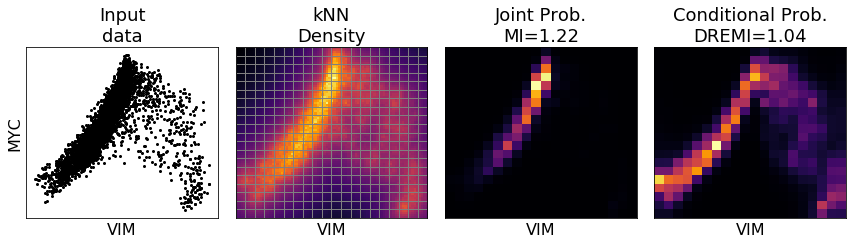

In [34]:
gene_x = 'VIM'
gene_y = 'MYC'

scprep.stats.knnDREMI(data_magic[gene_x], data_magic[gene_y], 
                      xlabel=gene_x, ylabel=gene_y, plot=True)

### Discussion

1. What do you notice about the difference between the DREMI plot on the right and the joint probability? 
2. Which gene trends might have high DREMI values, but low correlation?

# Identifying EMT-relevant genes using DREMI

In this section, we will identify genes that likely play a role in EMT due to their strong association with VIM. We will take the top 67% of genes and then cluster them to identify genes with similar DREVI plots so that we can determine their peak expression. We will use these orderings to narrow putative ZEB1 targets to genes that have peak expression with or after ZEB1. 

### Calculating DREMI scores

In this next code block, we use a tool called `joblib` to run DREMI across multiple threads and speed up the DREMI computation. The syntax for `joblib` is complicated, so we won't go into it. If you'd like to learn more about parallel processing and `joblib`, check out their excellent documentation: https://joblib.readthedocs.io/en/latest/parallel.html.

**Note:** to save time, we precomputed DREMI for you. You can uncomment the following code block to run the code yourself. It takes around 15 minutes in colab.

In [35]:
# # This is basically a parallel for-loop
# # Note we are getting both the DREMI scores and DREVI plots here so we need to unpack them
# from joblib import Parallel, delayed
# results = Parallel(n_jobs=4)(delayed(scprep.stats.knnDREMI)(data_magic['VIM'], data_magic[g], 
#                                      return_drevi=True, n_jobs=1) for g in data_magic.columns)
# 
# # Unpacking the DREMI scores and DREVI images
# vim_dremi_scores = np.array([r[0] for r in results])
# vim_drevi_images = np.array([r[1].flatten() for r in results])

#### Download precomputed DREMI results

DREMI is not particularly fast, and CoLab instances are fairly slow, so we already computed some DREMI relationships between all genes and VIM and all genes and ZEB1. This takes around 15 minutes in CoLab.

In [36]:
download_path = os.path.join(home, 'scRNAseq', 'Peer_2015_DREMI_data.npz')
if not os.path.exists(os.path.dirname(download_path)):
    os.makedirs(os.path.dirname(download_path))

    # Download the data 
if not os.path.exists(download_path):
    scprep.io.download.download_google_drive('1M21Z05omo_X5QIhQ8D07Tom31eo5-Ol8',download_path)
    
d = np.load(download_path)
vim_dremi_scores = d['vim_dremi_scores']
vim_drevi_images = d['vim_drevi_images']
zeb1_dremi_scores = d['zeb1_dremi_scores']

### Setting the threshold for EMT-related genes

If you have time later, try changing the percentile and see how that affects your predictions.

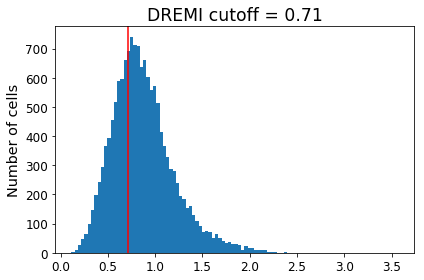

In [37]:
emt_cutoff = np.percentile(vim_dremi_scores, q=33)
scprep.plot.histogram(vim_dremi_scores, percentile=33, title='DREMI cutoff = {:.2f}'.format(emt_cutoff))

#### Create a mask over the genes for those above our threshold

In [38]:
emt_related_genes_mask = vim_dremi_scores > emt_cutoff

### Plotting the DREVI plots for the genes with the highest and smallest DREMI scores

Do these values look correct? Try selecting a gene in the middle of the distribution and examining that plot. 

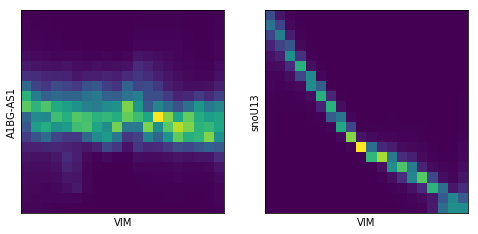

In [39]:
fig, axes = plt.subplots(1,2, figsize=(8,4))

ixs = [0, -2]
ordered_gene_indices = np.argsort(vim_dremi_scores)

for i, ax in enumerate(axes):
    curr_ix = ixs[i]
    ax.imshow(vim_drevi_images[ordered_gene_indices[curr_ix]].reshape(20,20), origin='lower')
    ax.set_xticks([]); ax.set_yticks([]);
    ax.set_xlabel('VIM')
    ax.set_ylabel(data.columns.values[curr_ix])

#### Create a mask over the genes for those above our threshold

In [40]:
emt_related_genes_mask = vim_dremi_scores > emt_cutoff

### Clustering genes by average DREVI images

To identify clusters of genes, we're going to use `AgglomerativeClustering`, a kind of hierarchical clustering method that iteratively joins the two points (or clusters) with the highest `affinity`. We are using `complete` linkage, which calculates the distance between two clusters that are being considered for merging using the two elements within each cluster with the largest distance between them. This process is repeated until `n_clusters` has been identified. Because van Dijk et al. (2018) identified 22 clusters, we're going to start with that.

You might be wondering, how do you cluster images? The answer is that we first flatten them, so we take the data from $\mathbb{R}^{20,20}$ and collapse them into $\mathbb{R}^{400}$. This loses some information about the grid-nature of the data, but it makes clustering much more straightforward. This is what Google probably does if they want to identify similar images for your Google Images search.

#### Running `AgglomerativeClustering`

This make take around a minute to complete.

In [41]:
agg_op = sklearn.cluster.AgglomerativeClustering(n_clusters=22, affinity='correlation', linkage='complete')
clusters = agg_op.fit_predict(vim_drevi_images[emt_related_genes_mask])

### Computing the "average" DREVI plot

Within each cluster, we are going to compute the "average" or mean DREVI plot. You may be most familiar with the arithmetic mean, but there are a number of other ways to calculate the mean. Here, we will use the geometric mean, which is defined as follows:

$$\sqrt[\leftroot{0}\uproot{2}\LARGE{n}]{\prod_{i=0}^{i=n}X_i}$$

You may notice the similarity between this an the arithmetic mean. Instead of adding the values and dividing by the number of observations, we are multiplying the values and taking the $n$th-root. This has the result of being less sensitive to extreme values in the data than the arithmetic mean. For a good explanation on the geometric mean, read Jasper McChesney's ["You should summarize data with the geometric mean"](https://medium.com/@JLMC/understanding-three-simple-statistics-for-data-visualizations-2619dbb3677a).

#### Calculating geometric mean DREVI plot for each cluster

In [42]:
mean_drevi = {}
for cl in np.unique(clusters):
    # Select images for the current cluster
    curr_images = vim_drevi_images[emt_related_genes_mask][clusters == cl]
    
    # Calculate the geometric mean
    mean_drevi[cl] = scipy.stats.gmean(curr_images, axis=0)

#### Plot the average DREVI plot

Let's look at the average DREVI plot per cluster.

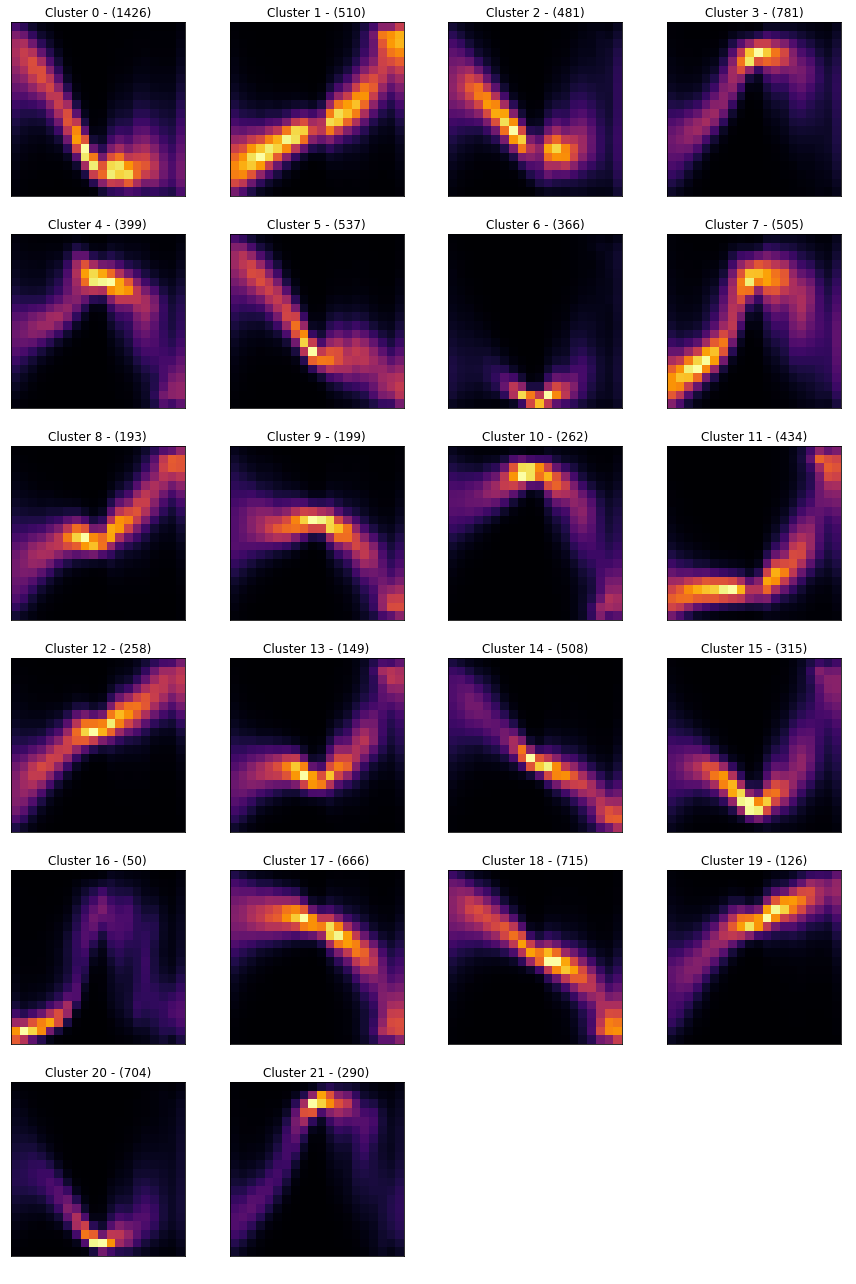

In [43]:
fig, axes = plt.subplots(6,4, figsize=(4*3,6*3))

for curr_cluster, ax in enumerate(axes.flatten()):
    if curr_cluster >= 22:
        ax.axis('off')
        continue
    curr_drevi = mean_drevi[curr_cluster].reshape(20,20)
    
    curr_n = np.sum(clusters == curr_cluster)
    ax.imshow(curr_drevi, origin='lower', cmap='inferno')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title('Cluster {} - ({})'.format(curr_cluster, curr_n))
    
fig.tight_layout()

### Ordering clusters by peak expression

Note that the clusters here are in no particular order. To order them by peak expression, we're going to take a simple approach. In each column, we will take the gridsquare with the highest intensity as the "average" expression for that gene cluster. With that in hand, we only need to identify the column with the peak expression based on the y-axis.

#### Plotting the "average" expression for one cluster

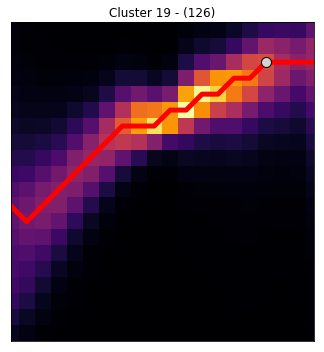

In [44]:
fig, ax = plt.subplots(1, figsize=(5,5))

# Pick your favorite cluster
curr_cluster = 19
curr_drevi = mean_drevi[curr_cluster].reshape(20,20)

# Plot DREVI
curr_n = np.sum(clusters == curr_cluster)
ax.imshow(curr_drevi, origin='lower', cmap='inferno')
ax.set_xticks([]); ax.set_yticks([])
ax.set_title('Cluster {} - ({})'.format(curr_cluster, curr_n))

# Plot the "average expression" and ID the peak
x = np.arange(20)
y = np.argmax(curr_drevi, axis=0)
x_peak = np.argmax(y)
y_peak = np.max(y)
ax.plot(x,y, c='r', linewidth=5)
ax.scatter(x_peak, y_peak, edgecolor='k', color='lightgrey', s=100, zorder=10)
ax.set_xlim(0,19)

fig.tight_layout()

#### Calculate peaks for all clusters

In [45]:
peaks = {}

for curr_cluster in np.unique(clusters):

    curr_drevi = mean_drevi[curr_cluster].reshape(20,20)
       
    x = np.arange(20)
    y = np.argmax(curr_drevi, axis=0)
    x_peak = np.argmax(y)
    y_peak = np.max(y)

    peaks[curr_cluster] = x_peak

#### Reorder the cluster labels so that cluster `0` has the earliest peak and cluster `22` has the latest

In [46]:
clusters = scprep.utils.sort_clusters_by_values(clusters, np.array([peaks[cl] for cl in clusters]))

#### Recalculate `mean_drevi` and `peaks`

In [47]:
mean_drevi = {}
for cl in np.unique(clusters):
    curr_images = vim_drevi_images[emt_related_genes_mask][clusters == cl]
    mean_drevi[cl] = scipy.stats.gmean(curr_images, axis=0)

In [48]:
peaks = {}

for curr_cluster in np.unique(clusters):

    curr_drevi = mean_drevi[curr_cluster].reshape(20,20)
       
    x = np.arange(20)
    y = np.argmax(curr_drevi, axis=0)
    x_peak = np.argmax(y)
    y_peak = np.max(y)

    peaks[curr_cluster] = x_peak

#### Plot new cluster labels ordered by peak expression

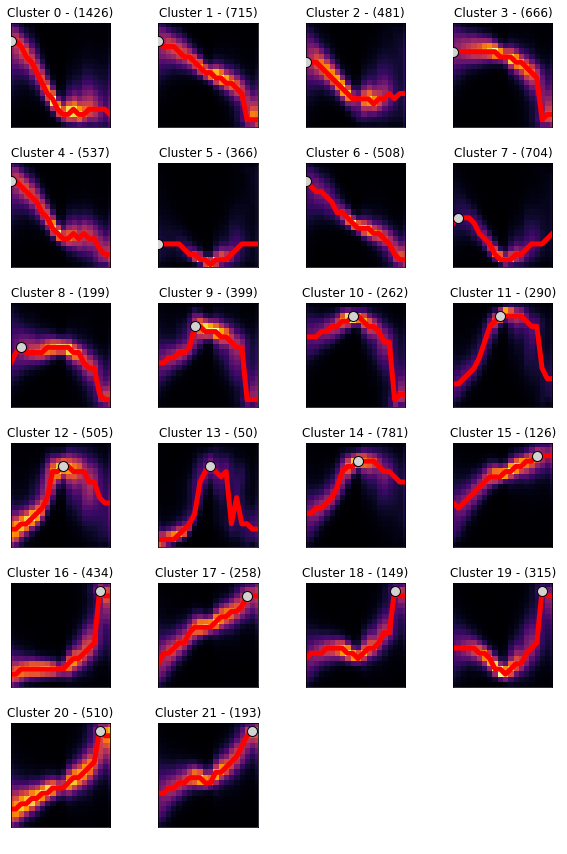

In [49]:
fig, axes = plt.subplots(6,4, figsize=(4*2,6*2))

for curr_cluster, ax in enumerate(axes.flatten()):
    if curr_cluster >= 22:
        ax.axis('off')
        continue
    curr_drevi = mean_drevi[curr_cluster].reshape(20,20)
    
    curr_n = np.sum(clusters == curr_cluster)
    ax.imshow(curr_drevi, origin='lower', cmap='inferno')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title('Cluster {} - ({})'.format(curr_cluster, curr_n))
    
    x = np.arange(20)
    y = np.argmax(curr_drevi, axis=0)
    x_peak = np.argmax(y)
    y_peak = np.max(y)
    ax.plot(x,y, c='r', linewidth=5)
    ax.scatter(x_peak, y_peak, edgecolor='k', color='lightgrey', s=100, zorder=10)
    ax.set_xlim(0,19)
fig.tight_layout()

## Transcription factor target prediction

Now that we have the order of expression for each gene cluster in the dataset, we can start to predict transcription factor targets. 

We're going to focus on ZEB1, a transcription factor and key regulator of EMT with poorly characterized regulatory targets.

### Identifying genes with association with ZEB1

Here, we'll rank each gene by its statistical association with ZEB1 just as we did with VIM above. Note this will take a couple minutes.

**Note:** to save time, we precomputed DREMI for you. You can uncomment the following code block to run the code yourself. It takes around 15 minutes in colab.

In [50]:
# zeb1_dremi_scores = Parallel(n_jobs=28)(delayed(scprep.stats.knnDREMI)(data_magic['ZEB1'], data_magic[g], n_jobs=1) for g in data_magic.columns)
# zeb1_dremi_scores = np.array(zeb1_dremi_scores)

#### Selecting genes with strongest association

Here, we're going to be much more selective than with our selection of EMT-related genes. We will start with a cutoff at the 98th-percentile.

Text(0.5, 1.0, 'DREMI scores with ZEB1')

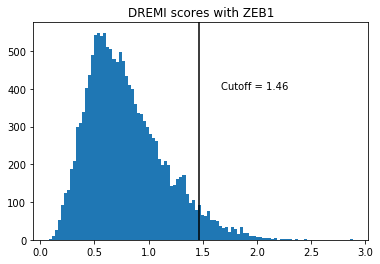

In [51]:
fig, ax = plt.subplots(1)

zeb1_dremi_cutoff = np.percentile(zeb1_dremi_scores, 95)

ax.hist(zeb1_dremi_scores, bins=100)
ax.axvline(zeb1_dremi_cutoff, color='k')
ax.text(zeb1_dremi_cutoff + 0.2, 400, 'Cutoff = {:.2f}'.format(zeb1_dremi_cutoff))
ax.set_title('DREMI scores with ZEB1')

#### Creating the ZEB1 dremi mask

In [52]:
zeb1_dremi_mask = zeb1_dremi_scores[emt_related_genes_mask] > zeb1_dremi_cutoff

#### Selecting genes that are expressed with or after ZEB1

Here, we'll identify when ZEB1 peaks based on it's cluster, and get all clusters that peak at the same time or later.

In [53]:
emt_gene_names = data.columns.values[emt_related_genes_mask]

In [54]:
# Get zeb1 cluster
zeb_ix = np.where(emt_gene_names == 'ZEB1')[0][0]
zeb_cluster = clusters[zeb_ix]

# Get the timing of the zeb1 peak
curr_drevi = mean_drevi[zeb_cluster].reshape(20,20)
y = np.argmax(curr_drevi, axis=0)
zeb1_peak = np.argmax(y)

# Create a mask identify genes in clusters that peak with or after ZEB1
timing_mask = np.array([peaks[cl] >= zeb1_peak for cl in clusters])

#### Combining DREMI and timing to get putative genes

In [55]:
putative_target_mask = timing_mask & zeb1_dremi_mask

#### Selecting gene names

In [56]:
putative_target_genes = emt_gene_names[putative_target_mask]
putative_target_genes_no_time = emt_gene_names[zeb1_dremi_mask]

**Discussion**: In pairs, design an experiment that you might perform to validate these targets.

## Comparing expression of putative targets after ZEB1 induction

van Dijk et al. 2018 performed an experiment to test the ZEB1 targets based on Dox-induction of ZEB1. The idea was that TGF-β leads to ZEB1 upregulation, but also turns on a whole host of other genes. By specifically inducing ZEB1 in the same cell line, we can determine which genes are upregulated specifically based on ZEB1 overexpression.

This dataset is already filtered and preprocessed, so we can work with it directly. We will calculate the fold change for each gene in the TGF-β sample and the ZEB1-induced sample and examine the distribution of fold-changes for 1) all genes 2) putative ZEB1 targets and 3) all genes with high DREMI with ZEB1, but not restricted to peak expression with or after ZEB1.

### Downloading the ZEB1 induced scRNA-seq data

In [57]:
home = os.path.expanduser('~')

download_path = os.path.join(home, 'scRNAseq', 'Peer_2015_ZEB1_induction.processed.pkl.gz')
if not os.path.exists(os.path.dirname(download_path)):
    os.makedirs(os.path.dirname(download_path))

    # Download the data 
if not os.path.exists(download_path):
    scprep.io.download.download_google_drive('14K2pqQNH0VpLKhv2vPjhUkQtnBoMhNhy',download_path)
    
data_dox = pd.read_pickle(download_path)

### Running PHATE

In [58]:
data_dox_phate = phate.PHATE().fit_transform(data_dox)

Calculating PHATE...
  Running PHATE on 3442 cells and 14723 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.64 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.44 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 3.29 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.44 seconds.
    Calculating KMeans...
    Calculated KMeans in 18.78 seconds.
  Calculated landmark operator in 20.50 seconds.
  Calculating optimal t...
    Automatically selected t = 12
  Calculated optimal t in 0.77 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.23 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 20.20 seconds.
Calculated PHATE in 45.01 seconds.


#### Running MAGIC

In [59]:
data_dox_magic = magic.MAGIC(t=4).fit_transform(data_dox)

Calculating MAGIC...
  Running MAGIC on 3442 cells and 14723 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.65 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.50 seconds.
    Calculating affinities...
    Calculated affinities in 2.19 seconds.
  Calculated graph and diffusion operator in 5.68 seconds.
  Calculating imputation...
  Calculated imputation in 0.63 seconds.
Calculated MAGIC in 7.59 seconds.


#### Plotting expression of EMT markers

You will need to fill in your code from above to make this cell work

In [90]:
fig, axes = plt.subplots(2,2,figsize=(8,8))

genes = ['CDH1','EPCAM', 'VIM', 'CDH2']
for i, ax in enumerate(axes.flatten()):
    # ========
    # Select the i'th gene from genes
    curr_gene = 
    # Select the column of `data` for `curr_gene`
    expression = 
    # ========
    scprep.plot.scatter2d(data_dox_phate, c=expression, 
                          title=curr_gene, ticks=None,
                          ax=ax)
    
fig.tight_layout()

SyntaxError: invalid syntax (<ipython-input-90-34ef6a9cdfa3>, line 6)

### Discussion

Compare this PHATE plot to the previous dataset. Do you think they are comparable? Why or why not?

### Calculating fold-changes

In [63]:
tgfb_mean = data[data_dox_magic.columns].mean(axis=0)
zeb1_mean = data_dox.mean(axis=0)
fc_expression = ( zeb1_mean - tgfb_mean) / tgfb_mean
log2_fc = np.log2(np.abs(fc_expression) + 1) * np.sign(fc_expression)

#### Look at the genes with largest fold-change

In [66]:
log2_fc[putative_target_genes].sort_values(ascending=False)

LSP1        4.390842
ZEB1        3.903673
RHOBTB3     3.398104
CPNE7       2.786966
GJC2        2.785862
              ...   
DPP4       -0.841539
CADPS2     -0.889529
TMEM204    -0.909799
ADAMTS12   -0.917237
MYADM      -0.934764
Length: 351, dtype: float64

### Plotting the distribution of fold-change per group

Here, we're using `sns.kdeplot` to create a [kernel-density estimate](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) of the fold-changes in each group. This is similar to a normalized histogram, and the area under the KDE plot sums to 1. This makes it more similar to a continuous probability density function. 

It also looks nicer than a histogram.

To see all the options for `kdeplot`, read the documentation: https://seaborn.pydata.org/generated/seaborn.kdeplot.html

Text(0, 0.5, 'Density')

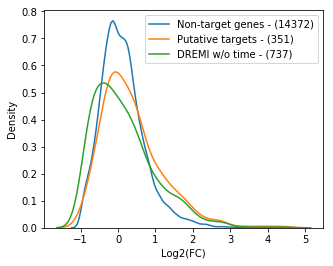

In [81]:
fig, ax = plt.subplots(1, figsize=(5,4))

# Plot all non-target genes
mask = ~np.isin(log2_fc.index, putative_target_genes)
sns.kdeplot(log2_fc[mask], ax=ax, label='Non-target genes - ({})'.format(np.sum(mask)))

# Plot the putative target genes 
mask = np.isin(log2_fc.index, putative_target_genes)
sns.kdeplot(log2_fc[mask], ax=ax, label='Putative targets - ({})'.format(np.sum(mask)))

# Plot the genes with the highest DREMI scores (not filtered for timing)
mask = np.isin(log2_fc.index, putative_target_genes_no_time)
sns.kdeplot(log2_fc[mask], ax=ax, label='DREMI w/o time - ({})'.format(np.sum(mask)))
ax.set_xlabel('Log2(FC)')
ax.set_ylabel('Density')

### Discussion

Why do you think that we don't observe stronger upregulation of putative target genes? Can you think of another experiment or style of analysis that might enrich for ZEB1 targets? Could we consider subclasses of cells to improve analysis?

## Plotting the interesction between ATAC validated hits and the putative targets

### About the experiment

From van Dijk et al. (2018)

> To systematically validate our target predictions, we used ATAC-seq (assay for transposase-accessible chromatin using sequencing) (Buenrostro et al., 2013) as an independent and well-accepted approach for target prediction (Kundaje et al., 2015). ATAC-seq was carried out on HMLE cells 8 days following TGF-β stimulation. Cells were FACS-sorted by CD44+ to enrich for the mesenchymal population. We used the ATAC-seq peaks combined with motif analysis to derive a set of targets for each TF using standard approaches (see STAR Methods). Note, we do not expect the two approaches to perfectly align: our predictions identify both direct and indirect targets of a TF, whereas ATAC-seq only captures direct targets. ATAC-seq identifies binding of TFs that are activating, poised, or inhibiting, whereas our predictions only focus on TF activation. Nevertheless, if our predictions are accurate, we expect a significant overlap between the two sets.

Here, we're just downloading the list of validated targets that we'll use to:
1. Determine the overlap between ATAC-seq predicted targets and the DREMI targets
2. Examine the change in expression of the ATAC-seq targets in the ZEB1 dox experiment
3. Perform gene set enrichment analysis

If you want to learn more about how these targets were predicted, navigate to the "ATAC-seq Validation of TF-target Predictions" section of the MAGIC paper (https://doi.org/10.1016/j.cell.2018.05.061).

###  Downloading validated ATAC-seq targets

In [68]:
home = os.path.expanduser('~')

download_path = os.path.join(home, 'scRNAseq', 'Peer_2015_ATAC_validated_targets.pkl.gz')
if not os.path.exists(os.path.dirname(download_path)):
    os.makedirs(os.path.dirname(download_path))

    # Download the data 
if not os.path.exists(download_path):
    scprep.io.download.download_google_drive('1SUU_rLlKNTrWc7KV0t2txCBeIO-DpwLn',download_path)
    
atac_hits = pd.read_pickle(download_path)

#### How to navigate this DataFrame

In `atac_hits`, rows are transcription factors and columns are targets. The presence of a `1` in the DataFrame indicates that the TF is predicted to bind the target. A `0` indicates the lack potential binding.

In [69]:
atac_hits.head()

,A1BG-AS1,A2ML1,A4GALT,AAAS,AACS,AADAT,AAED1,AAGAB,AAK1,AAMDC,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZYG11A,ZYX,ZZZ3,chr22-38_28785274-29006793.1,uc_33
AHR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
ARID3A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ARID5B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
ARNT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
ARNTL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [70]:
# This gets the whole row
validated_hits = atac_hits.loc['ZEB1']
# Here we get the gene names for the non-zero targets
validated_hits = validated_hits[validated_hits == 1].index.values

In [71]:
validated_hits

array(['AARS', 'ABCC13', 'ABCC3', ..., 'ZSWIM6', 'ZXDB', 'ZYX'],
      dtype=object)

#### Get the number of genes overlapping in `validated_hits` and `putative_target_genes`

Here, you will need to use `np.intersect1d` to get the intersection of each array. For reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.intersect1d.html

In [72]:
# ======
# Write code to get the size of each array and the intersection
size_dremi_targets = 
size_atac_targets  = 
size_intersection  = 

print('Of {} DREMI targets and {} ATAC-validated targets, {} genes overlap.'.format(size_dremi_targets, 
                                                                   size_atac_targets, size_intersection))
# ======

SyntaxError: invalid syntax (<ipython-input-72-f05c27fb4797>, line 3)

#### Plotting the fold-change in expression of the ATAC-validated hits

Copy the code from [the previous KDE plot](#Plotting-the-distribution-of-fold-change-per-group), and add a line to plot the ATAC-seq validated hits

Text(0.5, 0, 'Log2(FC)')

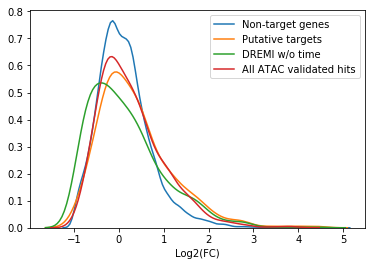

In [75]:
# ======
# Copy
ax = sns.kdeplot(log2_fc[~np.isin(log2_fc.index, putative_target_genes)], label='Non-target genes')
sns.kdeplot(log2_fc[putative_target_genes], ax=ax, label='Putative targets')
sns.kdeplot(log2_fc[putative_target_genes_no_time], label='DREMI w/o time', ax=ax)
sns.kdeplot(log2_fc[np.isin(log2_fc.index, validated_hits)], label='All ATAC validated hits', ax=ax)
ax.set_xlabel('Log2(FC)')
# ======

### Discussion

What do you notice about the distribution of expression values for the ATAC-validated targets?
How does this influence your interpreation of the ZEB1 induction experiment?

## Gene set enrichment analysis

As before, we will use EnrichR to perform gene set enrichment analysis. For this section we are going to take each gene list, and determine which gene sets are enriched and how strongly.

Each pair should:

1. Get a list of GO Biological Process sets that are enriched in the  
    A. DREMI-predicted targets  
    B. ATAC targets  
    C. Intersection of DREMI and ATAC-seq targets  
2. Of the shared enriched terms, compare the Combined Scores
3. Which gene set has the highest enrichment for gene sets that appear relevant to EMT?

You may use either the EnrichR website (https://amp.pharm.mssm.edu/Enrichr/) or the `gseapy` python module. If you wish to use gseapy, consult the previous notebook for code.

In [118]:
for gene in putative_target_genes:
    print(gene)

ABHD2
ABL1
ABLIM3
AC002454.1
AC016549.1
AC068137.13
AC133965.1
ACAA2
ACOT2
ACOX3
ADAM12
ADAMTS12
ADAMTS6
AEBP1
AF131215.9
AHDC1
AKT3
ALCAM
AMIGO2
ANKLE1
ANKRD28
ANPEP
ANTXR1
AOX1
APBB2
APPBP2
APPL2
ARAP3
ARL10
ARL17B
ARL3
ARL4A
ARNTL
ARRDC2
ASTE1
ATP2B1
ATP5G2
ATP8B2
ATP8B3
BBS10
BCAT1
BIN1
BIRC3
BLOC1S5
BRD3
BRPF3
C12orf76
C5orf15
C5orf22
C5orf24
CADPS2
CAMK1
CAPRIN2
CCDC80
CDC42EP3
CDH2
CDH4
CDK15
CEP112
CEP170
CHID1
CHN1
CHST14
CHST7
CHSY1
CLK4
CNTNAP1
COL13A1
COL4A1
COL4A2
CPED1
CPNE7
CREB3L2
CRIM1
CSF1
CTB-152G17.6
CTC-459F4.3
CTC-487M23.6
CTD-2231E14.2
CTD-2530N21.5
CXCL3
CXCL5
CYR61
CYTH3
DCBLD1
DCDC2
DDAH1
DENND3
DENND5A
DENND5B
DKK1
DLC1
DNAJC28
DNM1
DOCK1
DOCK10
DPP4
DPYD
DSEL
DUSP1
DUSP23
EID1
ENG
EPS8
ERBB2IP
ERRFI1
EVA1B
F10-AS1
FABP4
FADS1
FAM114A2
FAT4
FBXO34
FERMT2
FGF1
FGFR1
FHL3
FKBP7
FOXC2
FRG1B
FRMD6
FTO-IT1
FZD1
GALK1
GALNT1
GALNT10
GJC2
GLYATL2
GNG4
GPR17
GPR176
GPSM3
GPX8
GS1-309P15.4
GTF2IRD2
GXYLT2
HAS2
HDGFRP3
HEG1
HERC3
HHIP-AS1
HIF1A
HINFP
HIPK2
HIVEP3
HNRNP